In [1]:
import pandas as pd
import csv
import string
from string import digits
import numpy as np

In [2]:
import nltk

## Audi Topic Modeling

In [3]:
df=pd.read_csv(r"C:\Users\VoramatePasharawipas\Desktop\MSA-MRM GSU\Course\4-Fall 2019\Text Analytic\Finalproject\Final_Project_Data\Tesla.csv",sep=",")
df.head()

,comment,comment_id,post_id,post_time,post_title,time
0,[],[],bv2t6n,1.559275e+09,Configurator live in Australi,[]
1,Reminder that the wall charger is included in ...,epkqq0x,bv2t27,1.559275e+09,Australian model 3 Configurator is live!,1559279265.0
2,Blue Performance Model confirmed.,epkl3uo,bv2t27,1.559275e+09,Australian model 3 Configurator is live!,1559276227.0
3,New Zealand is live too. Base SR+ for $75k. Sa...,epklx56,bv2t27,1.559275e+09,Australian model 3 Configurator is live!,1559276633.0
4,Congrats. Coming pretty soon in August too. I ...,epklo12,bv2t27,1.559275e+09,Australian model 3 Configurator is live!,1559276508.0


In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\VoramatePasharawipas\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
data = df.comment.values.tolist()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[[]]


In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [8]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['', 'reminder wall charger be include price australia new zealand wall connector be include new vehicle standard equipment tesla recommend wall connector most dynamic home charge hardware model model model customisable almost power supply wall connector will provide faster charge speed most convenience home charge https www tesla com support home charge installation redirect https www tesla com support home charge installation redirect https www tesla com support home charge installation redirect https www tesla com en_au support home charge installation redirect']


In [9]:
data_lemmatized

['',
 'reminder wall charger be include price australia new zealand wall connector be include new vehicle standard equipment tesla recommend wall connector most dynamic home charge hardware model model model customisable almost power supply wall connector will provide faster charge speed most convenience home charge https www tesla com support home charge installation redirect https www tesla com support home charge installation redirect https www tesla com support home charge installation redirect https www tesla com en_au support home charge installation redirect',
 'blue performance model confirm',
 'new zealand be live too base same option australia same delivery estimate too august reservation ask tesla sale person when call have test drive model available say don have idea when would think probably when first batch order arrive',
 'congrat come pretty soon august too sadly can fork right now will be exciting see road here',
 'standard range autopilot come well luxury car tax thre

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

C:\Users\VoramatePasharawipas\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['reminder', 'that', 'the', 'wall_charger', 'is', 'included', 'in', 'that', 'price', 'for', 'australia', 'and', 'new', 'zealand', 'the', 'wall_connector', 'is', 'included', 'with', 'all', 'new', 'vehicles', 'as', 'standard', 'equipment', 'tesla', 'recommends', 'the', 'wall_connector', 'as', 'the', 'most', 'dynamic', 'home', 'charging', 'hardware', 'for', 'model', 'model', 'and', 'model', 'customisable', 'to', 'almost', 'any', 'power', 'supply', 'the', 'wall_connector', 'will', 'provide', 'faster', 'charging', 'speeds', 'and', 'the', 'most', 'convenience', 'for', 'home', 'charging', 'https', 'www', 'tesla', 'com', 'en', 'support', 'home', 'charging', 'installation', 'redirect', 'no', 'https', 'www', 'tesla', 'com', 'en_nz', 'support', 'home', 'charging', 'installation', 'redirect', 'no', 'https', 'www', 'tesla', 'com', 'en', 'support', 'home', 'charging', 'installation', 'redirect', 'no', 'https', 'www', 'tesla', 'com', 'en_au', 'support', 'home', 'charging', 'installation', 'redirect',

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VoramatePasharawipas\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['work',
                   'great',
                   'good',
                   'from', 
                   'subject',
                   're', 
                   'edu', 
                   'use','take','love','thing','wrong','never','car',
                   'think','go',
                   'well','also','really','nice','bad'])

In [14]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Remove Stop Words
data_lemmatized = remove_stopwords(data_lemmatized)


print(data_lemmatized[:1])

[[]]


In [17]:
data_lemmatized

[[],
 ['reminder',
  'wall',
  'charger',
  'include',
  'price',
  'australia',
  'new',
  'zealand',
  'wall_connector',
  'include',
  'new',
  'vehicle',
  'standard',
  'equipment',
  'tesla',
  'recommend',
  'wall_connector',
  'dynamic',
  'home',
  'charge',
  'hardware',
  'model',
  'model',
  'model',
  'customisable',
  'almost',
  'power',
  'supply',
  'wall_connector',
  'provide',
  'faster',
  'charge',
  'speed',
  'convenience',
  'home',
  'charge',
  'https',
  'www',
  'tesla',
  'com',
  'support',
  'home',
  'charge',
  'installation',
  'redirect',
  'https',
  'www',
  'tesla',
  'com',
  'support',
  'home',
  'charge',
  'installation',
  'redirect',
  'https',
  'www',
  'tesla',
  'com',
  'support',
  'home',
  'charge',
  'installation',
  'redirect',
  'https',
  'www',
  'tesla',
  'com',
  'en_au',
  'support',
  'home',
  'charge',
  'installation',
  'redirect'],
 ['blue', 'performance', 'model', 'confirm'],
 ['new',
  'zealand',
  'live',
  'base

## Create the Dictionary and Corpus needed for Topic Modeling

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[],
 [('almost', 1),
  ('australia', 1),
  ('charge', 7),
  ('charger', 1),
  ('com', 4),
  ('convenience', 1),
  ('customisable', 1),
  ('dynamic', 1),
  ('en_au', 1),
  ('equipment', 1),
  ('faster', 1),
  ('hardware', 1),
  ('home', 6),
  ('https', 4),
  ('include', 2),
  ('installation', 4),
  ('model', 3),
  ('new', 2),
  ('power', 1),
  ('price', 1),
  ('provide', 1),
  ('recommend', 1),
  ('redirect', 4),
  ('reminder', 1),
  ('speed', 1),
  ('standard', 1),
  ('supply', 1),
  ('support', 4),
  ('tesla', 5),
  ('vehicle', 1),
  ('wall', 1),
  ('wall_connector', 3),
  ('www', 4),
  ('zealand', 1)]]

## Building the Topic Model

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.070*"right" + 0.062*"already" + 0.048*"post" + 0.036*"someone" + '
  '0.035*"low" + 0.034*"deal" + 0.031*"find" + 0.027*"happy" + 0.024*"road" + '
  '0.022*"little"'),
 (1,
  '0.065*"come" + 0.055*"drop" + 0.045*"elon" + 0.042*"try" + 0.036*"customer" '
  '+ 0.035*"offer" + 0.032*"issue" + 0.028*"stop" + 0.027*"let" + '
  '0.022*"sense"'),
 (2,
  '0.155*"people" + 0.048*"lot" + 0.034*"anything" + 0.031*"agree" + '
  '0.031*"show" + 0.028*"mile" + 0.026*"ap" + 0.023*"lane" + 0.020*"increase" '
  '+ 0.018*"true"'),
 (3,
  '0.143*"com" + 0.142*"https" + 0.044*"twitter" + 0.032*"www" + '
  '0.027*"almost" + 0.024*"create" + 0.024*"hold" + 0.021*"lr" + 0.021*"bot" + '
  '0.020*"imgur"'),
 (4,
  '0.117*"feature" + 0.076*"range" + 0.044*"reason" + 0.039*"close" + '
  '0.036*"number" + 0.032*"bit" + 0.025*"hard" + 0.022*"confirm" + 0.020*"fee" '
  '+ 0.020*"supercharger"'),
 (5,
  '0.129*"pay" + 0.077*"purchase" + 0.070*"change" + 0.060*"give" + '
  '0.058*"day" + 0.035*"seem" + 0.03

## Compute Model Perplexity and Coherence Score

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.306519198003233

Coherence Score:  0.5651715306034376


## Visualize the topics-keywords

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
pyLDAvis.save_html(vis, 'lda_20.html')

C:\Users\VoramatePasharawipas\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


## Building LDA Mallet Model

In [23]:
import os
# Mallet env variable and path for Windows 10 in B:/ drive
os.environ.update({'MALLET_HOME': r'C:/Users/VoramatePasharawipas/Desktop/mallet-2.0.8'})
mallet_path = 'C:/Users/VoramatePasharawipas/Desktop/mallet-2.0.8/bin/mallet'

In [24]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [25]:
# Visualize the topics
import gensim    
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.save_html(vis, 'ldamallet_20.html')

In [26]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(8,
  [('elon', 0.04012874658471498),
   ('musk', 0.0160751385435088),
   ('state', 0.01253824437301959),
   ('tweet', 0.011551732759913988),
   ('fact', 0.009828747039328626),
   ('law', 0.009737824310010138),
   ('sec', 0.009610532488964254),
   ('claim', 0.00939231793859988),
   ('public', 0.00936049498333841),
   ('word', 0.008869512245018571)]),
 (11,
  [('tesla', 0.034165642136486936),
   ('make', 0.030916417852194445),
   ('truck', 0.028833206486739652),
   ('big', 0.024993657670315944),
   ('production', 0.02241281736041996),
   ('build', 0.021398044610971254),
   ('start', 0.02133950002927229),
   ('line', 0.021061413266202214),
   ('design', 0.01714380500751322),
   ('end', 0.01449954140077669)]),
 (1,
  [('model', 0.19336259707684145),
   ('year', 0.03358255752255077),
   ('tesla', 0.022406058559644976),
   ('compare', 0.0188895856446867),
   ('big', 0.01701316868457865),
   ('performance', 0.012966089431286479),
   ('small', 0.0127249047320438),
   ('high', 0.0120351164922

## the optimal number of topics for LDA

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

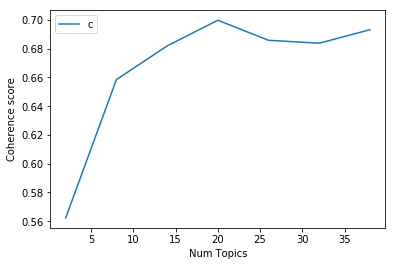

In [31]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5623
Num Topics = 8  has Coherence Value of 0.6585
Num Topics = 14  has Coherence Value of 0.6819
Num Topics = 20  has Coherence Value of 0.6998
Num Topics = 26  has Coherence Value of 0.6858
Num Topics = 32  has Coherence Value of 0.6838
Num Topics = 38  has Coherence Value of 0.6932


In [33]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.093*"tesla" + 0.049*"make" + 0.022*"company" + 0.019*"year" + '
  '0.016*"sell" + 0.013*"money" + 0.011*"part" + 0.010*"market" + 0.008*"big" '
  '+ 0.008*"production"'),
 (1,
  '0.022*"people" + 0.014*"point" + 0.013*"post" + 0.012*"elon" + 0.010*"read" '
  '+ 0.010*"agree" + 0.009*"question" + 0.009*"talk" + 0.008*"datum" + '
  '0.008*"case"'),
 (2,
  '0.085*"model" + 0.055*"tesla" + 0.050*"https" + 0.030*"vehicle" + '
  '0.016*"full" + 0.015*"www" + 0.015*"software" + 0.014*"autopilot" + '
  '0.013*"delete" + 0.011*"performance"'),
 (3,
  '0.046*"drive" + 0.027*"time" + 0.025*"change" + 0.018*"lane" + 0.017*"road" '
  '+ 0.017*"stop" + 0.014*"driver" + 0.014*"turn" + 0.013*"happen" + '
  '0.012*"speed"'),
 (4,
  '0.041*"pron" + 0.039*"buy" + 0.035*"price" + 0.028*"year" + 0.028*"pay" + '
  '0.027*"fsd" + 0.020*"month" + 0.019*"order" + 0.017*"wait" + 0.017*"week"'),
 (5,
  '0.198*"pron" + 0.026*"people" + 0.015*"feel" + 0.013*"pretty" + 0.013*"lot" '
  '+ 0.012*"make" + 0.

## Finding the dominant topic in each sentence

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1250,"tesla, make, company, year, sell, money, part,...",[]
1,1,2.0,0.3106,"model, tesla, https, vehicle, full, www, softw...",Reminder that the wall charger is included in ...
2,2,2.0,0.1672,"model, tesla, https, vehicle, full, www, softw...",Blue Performance Model confirmed.
3,3,4.0,0.2194,"pron, buy, price, year, pay, fsd, month, order...",New Zealand is live too. Base SR+ for $75k. Sa...
4,4,5.0,0.1623,"pron, people, feel, pretty, lot, make, truck, ...",Congrats. Coming pretty soon in August too. I ...
5,5,3.0,0.1447,"drive, time, change, lane, road, stop, driver,...",Standard Range + with Autopilot comes in well ...
6,6,7.0,0.2101,"charge, mile, battery, range, time, long, powe...",RIP to the following NZ casualties: \n\n* The ...
7,7,4.0,0.1713,"pron, buy, price, year, pay, fsd, month, order...",$71840 in NSW for SR+\n\nDelivery in August
8,8,2.0,0.1389,"model, tesla, https, vehicle, full, www, softw...",I’m going to hold out for the LR AWD
9,9,4.0,0.1725,"pron, buy, price, year, pay, fsd, month, order...","Shit, you beat me. That'll teach me to stop an..."


## Find the most representative document for each topic

In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5488,"tesla, make, company, year, sell, money, part,...",That might be true. But the problem is no auto...
1,1.0,0.6104,"people, point, post, elon, read, agree, questi...","To be clear, this relates to the shareholder l..."
2,2.0,0.7966,"model, tesla, https, vehicle, full, www, softw...","Acronyms, initialisms, abbreviations, contract..."
3,3.0,0.5989,"drive, time, change, lane, road, stop, driver,...",I tried NoA without confirmation on and I was ...
4,4.0,0.5606,"pron, buy, price, year, pay, fsd, month, order...","Yes, Its more money, but its the exact same pr..."


## Topic distribution across documents

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics[:20]

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"tesla, make, company, year, sell, money, part,...",57501.0,0.1594
1,2.0,"model, tesla, https, vehicle, full, www, softw...",44986.0,0.1247
2,2.0,"model, tesla, https, vehicle, full, www, softw...",38776.0,0.1075
3,4.0,"pron, buy, price, year, pay, fsd, month, order...",39773.0,0.1103
4,5.0,"pron, people, feel, pretty, lot, make, truck, ...",47125.0,0.1306
5,3.0,"drive, time, change, lane, road, stop, driver,...",45789.0,0.1269
6,7.0,"charge, mile, battery, range, time, long, powe...",48833.0,0.1354
7,4.0,"pron, buy, price, year, pay, fsd, month, order...",37935.0,0.1052
8,2.0,"model, tesla, https, vehicle, full, www, softw...",NaN,NaN
9,4.0,"pron, buy, price, year, pay, fsd, month, order...",NaN,NaN
